# Label and train notebook YOLO DS-IA

In [1]:
NOTEBOOK_CONFIG = {
    "label_mode": True,
    "train_mode": True,
    "IMG_LENGTH": 0.377,
    "IMG_WIDTH": 0.143,
    "IMG_XDIM": 143,
    "IMG_YDIM": 377,
    "labels_type": "Labelsv0_detect",
    "task": "detect",
    "yolo_type": "YOLOv0_detect",
}

In [2]:
# Folders
# Location of images
images_folder = f"../docs/Data/Images/"
# Locations of yolo's datasets
yolo_folder = f"../docs/Models/{NOTEBOOK_CONFIG['yolo_type']}/datasets/"
# Location of labels
labels_folder = f"../docs/Data/{NOTEBOOK_CONFIG['labels_type']}/"
# Location of trained models
model_folder = f"../docs/Models/{NOTEBOOK_CONFIG['yolo_type']}/"

In [3]:
# Path for sample image
n_image = 3
image_path = f"../docs/Data/Images/gaussian_{n_image}.png"
label_path = f"../docs/Data/{NOTEBOOK_CONFIG['labels_type']}/gaussian_{n_image}.txt"

In [ ]:
# If folder on Google drive
from google.colab import drive

drive.mount("/content/gdrive")

In [5]:
import os
import shutil
from pathlib import Path
import pandas as pd
from datetime import datetime
import scipy

from matplotlib import pyplot as plt

In [ ]:
from PIL import Image
from ultralytics import YOLO
from ultralytics.utils import plotting

# Load modules

In [6]:
import sys

sys.path.append("..")

In [11]:
from pipelines.pipelines import ppl_label_YOLOv0, ppl_distribute_images_yolo
from helpers.gaussian_generator import generate_grid
from helpers.auxiliary_functions import load_label
from helpers.aux_plotter import gaussians_labelled, plot_grayscale

# Data from CNR

## Load
- Real size of the tile is roughly equal to 2 pixel / mm

In [ ]:
# Load 400 gaussians
mat = scipy.io.loadmat("../docs/Data/db_80beam.mat")
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'F_data', 'Fit_flux', 'beta'])


In [ ]:
# Generate GRID
x, y = generate_grid(
    (0, NOTEBOOK_CONFIG["IMG_WIDTH"]),
    (0, NOTEBOOK_CONFIG["IMG_LENGTH"]),
    NOTEBOOK_CONFIG["IMG_XDIM"],
    NOTEBOOK_CONFIG["IMG_YDIM"],
)

# [ESTIMATION DS-IA]
- Images: 0 - 200 (Gaussians with only overlapping in y-direction)
  - All amplitudes are higher around 1.5E6 (250%)
  - x center coincides with beta xs
  - y center It has some Gaussians deslocated to up and other to down around 0.01 in y direction
  - dispersion in x Higher dispersion in x directions around 0.003 (40%)
  - dispersion in y Higher dispersion in y direction around 0.002 (40%)


## [ESTIMATION] Pipeline ppl_Yolo

### Gaussians labelling for Yolo

In [ ]:
"""Generating labels - Here is the labelling of the images,
not the structuring in folders
"""
if NOTEBOOK_CONFIG["label_mode"]:
    ppl_label_YOLOv0(
        mat["F_data"],
        mat["Fit_flux"],
        f"../docs/Data/{NOTEBOOK_CONFIG['labels_type']}",
        remove_out_of_image=True,
        task=NOTEBOOK_CONFIG["task"],
        n_contour_points=None,
        octagon_pol=False,
    )

Number of indentifiable Gaussians (center in the image): 79


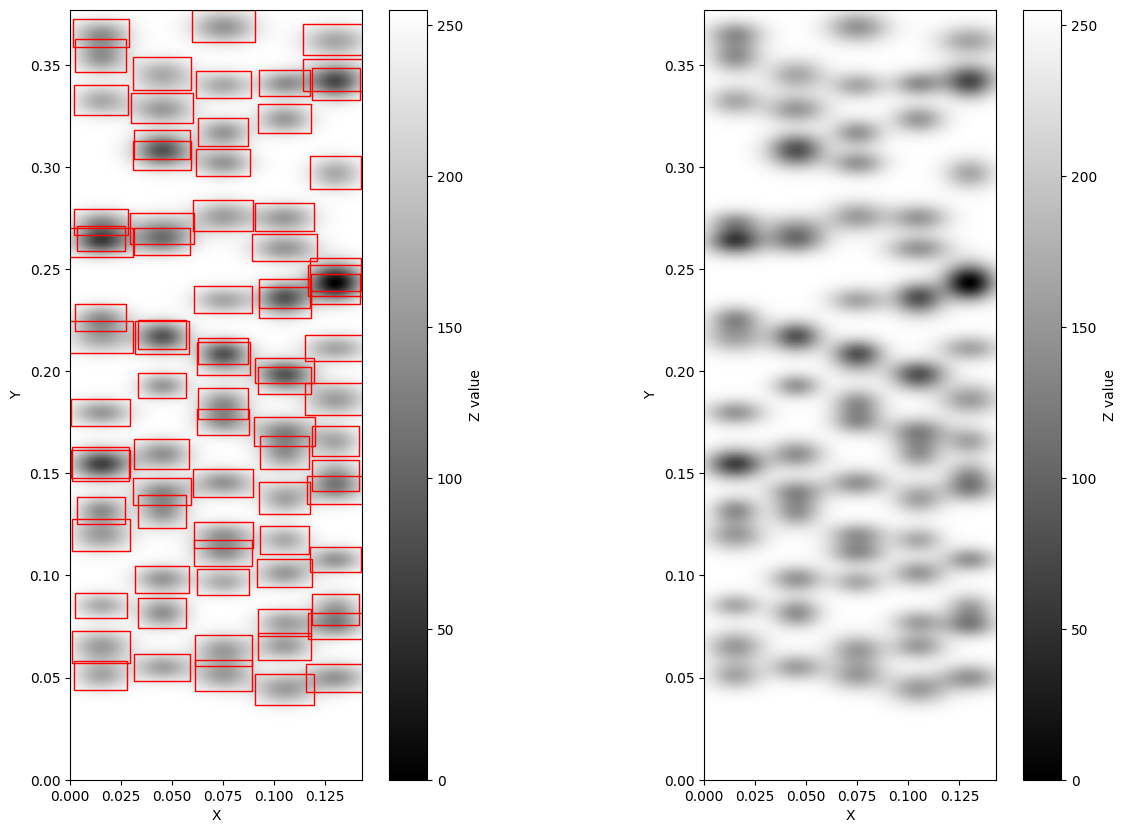

In [ ]:
# Plot ground truth labels
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
x, y, z = gaussians_labelled(
    image_path, label_path, axs[0], task=NOTEBOOK_CONFIG["task"]
)

plot_grayscale(x, y, z, ax=axs[1])

In [ ]:
# Labels problem in Yolo
lines = load_label(label_path).split("\n")
# Step 2: Split each line into columns using spaces as the separator
labels = [line.split() for line in lines]
df_labels = pd.DataFrame(labels)

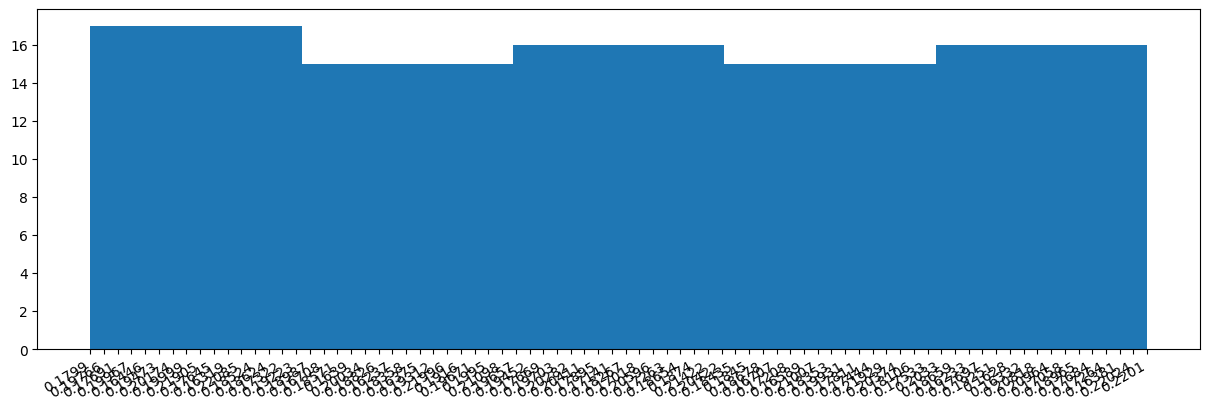

In [ ]:
# Labels histogram
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(df_labels[[3]], bins=5)
fig.autofmt_xdate()

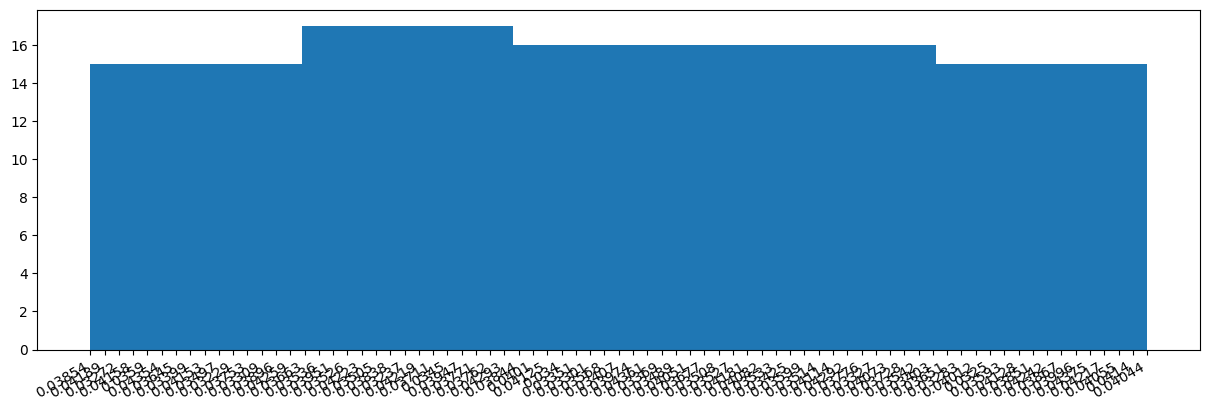

In [ ]:
# Labels histogram
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(df_labels[[4]], bins=5)
fig.autofmt_xdate()

### Yolo structure - distribute images in folder

In [ ]:
"""
Image distribution for YoloV0
  - Images from 0 to 200
  - Labels without  gaussians with center out of the image
"""
range_images = list(range(200))
proportions = {"train": 0.7, "val": 0.2, "test": 0.1}

if NOTEBOOK_CONFIG["label_mode"]:
    ppl_distribute_images_yolo(
        images_folder, labels_folder, yolo_folder, range_images, proportions
    )

In [ ]:
# Config Yolo model to train
yaml_content = f"""
                train: {os.path.join(model_folder, "datasets/train/images")}
                val: {os.path.join(model_folder, "datasets/val/images")}
                test: {os.path.join(model_folder, "datasets/test/images")}
                names: ['gaussian']
                """

if NOTEBOOK_CONFIG["label_mode"]:
    with open(os.path.join(model_folder, "data.yaml"), "w") as f:
        f.write(yaml_content)

### Training model - YOLOv0

In [ ]:
# Load nano model
model = YOLO("yolov8s.pt")  # "yolov8s-seg.pt"

In [ ]:
# Train
model_name = "YOLOv0_detect"
if NOTEBOOK_CONFIG["train_mode"]:
    results = model.train(
        device=0,  # "cpu"
        batch=-1,
        patience=100,
        task=NOTEBOOK_CONFIG["task"],
        data=os.path.join(model_folder, "data.yaml"),
        epochs=100,
    )

Ultralytics YOLOv8.0.142 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_detect/data.yaml, epochs=100, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=

In [ ]:
# Copy results (If in Google Colab)
if NOTEBOOK_CONFIG["train_mode"]:
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    shutil.copytree(
        Path("/content/runs/"), Path(f"../docs/Models/{model_name}/runs/{timestamp}")
    )

PosixPath('/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_detect/runs/2023-07-26_18-50-24')

In [ ]:
# Plot results (if in Google Colab)
plotting.plot_results(f"/content/runs/{NOTEBOOK_CONFIG['task']}/train/results.csv")
image = Image.open(f"/content/runs/{NOTEBOOK_CONFIG['task']}/train/results.png")
fig = plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis("off")  # Turn off axis labels
plt.show()

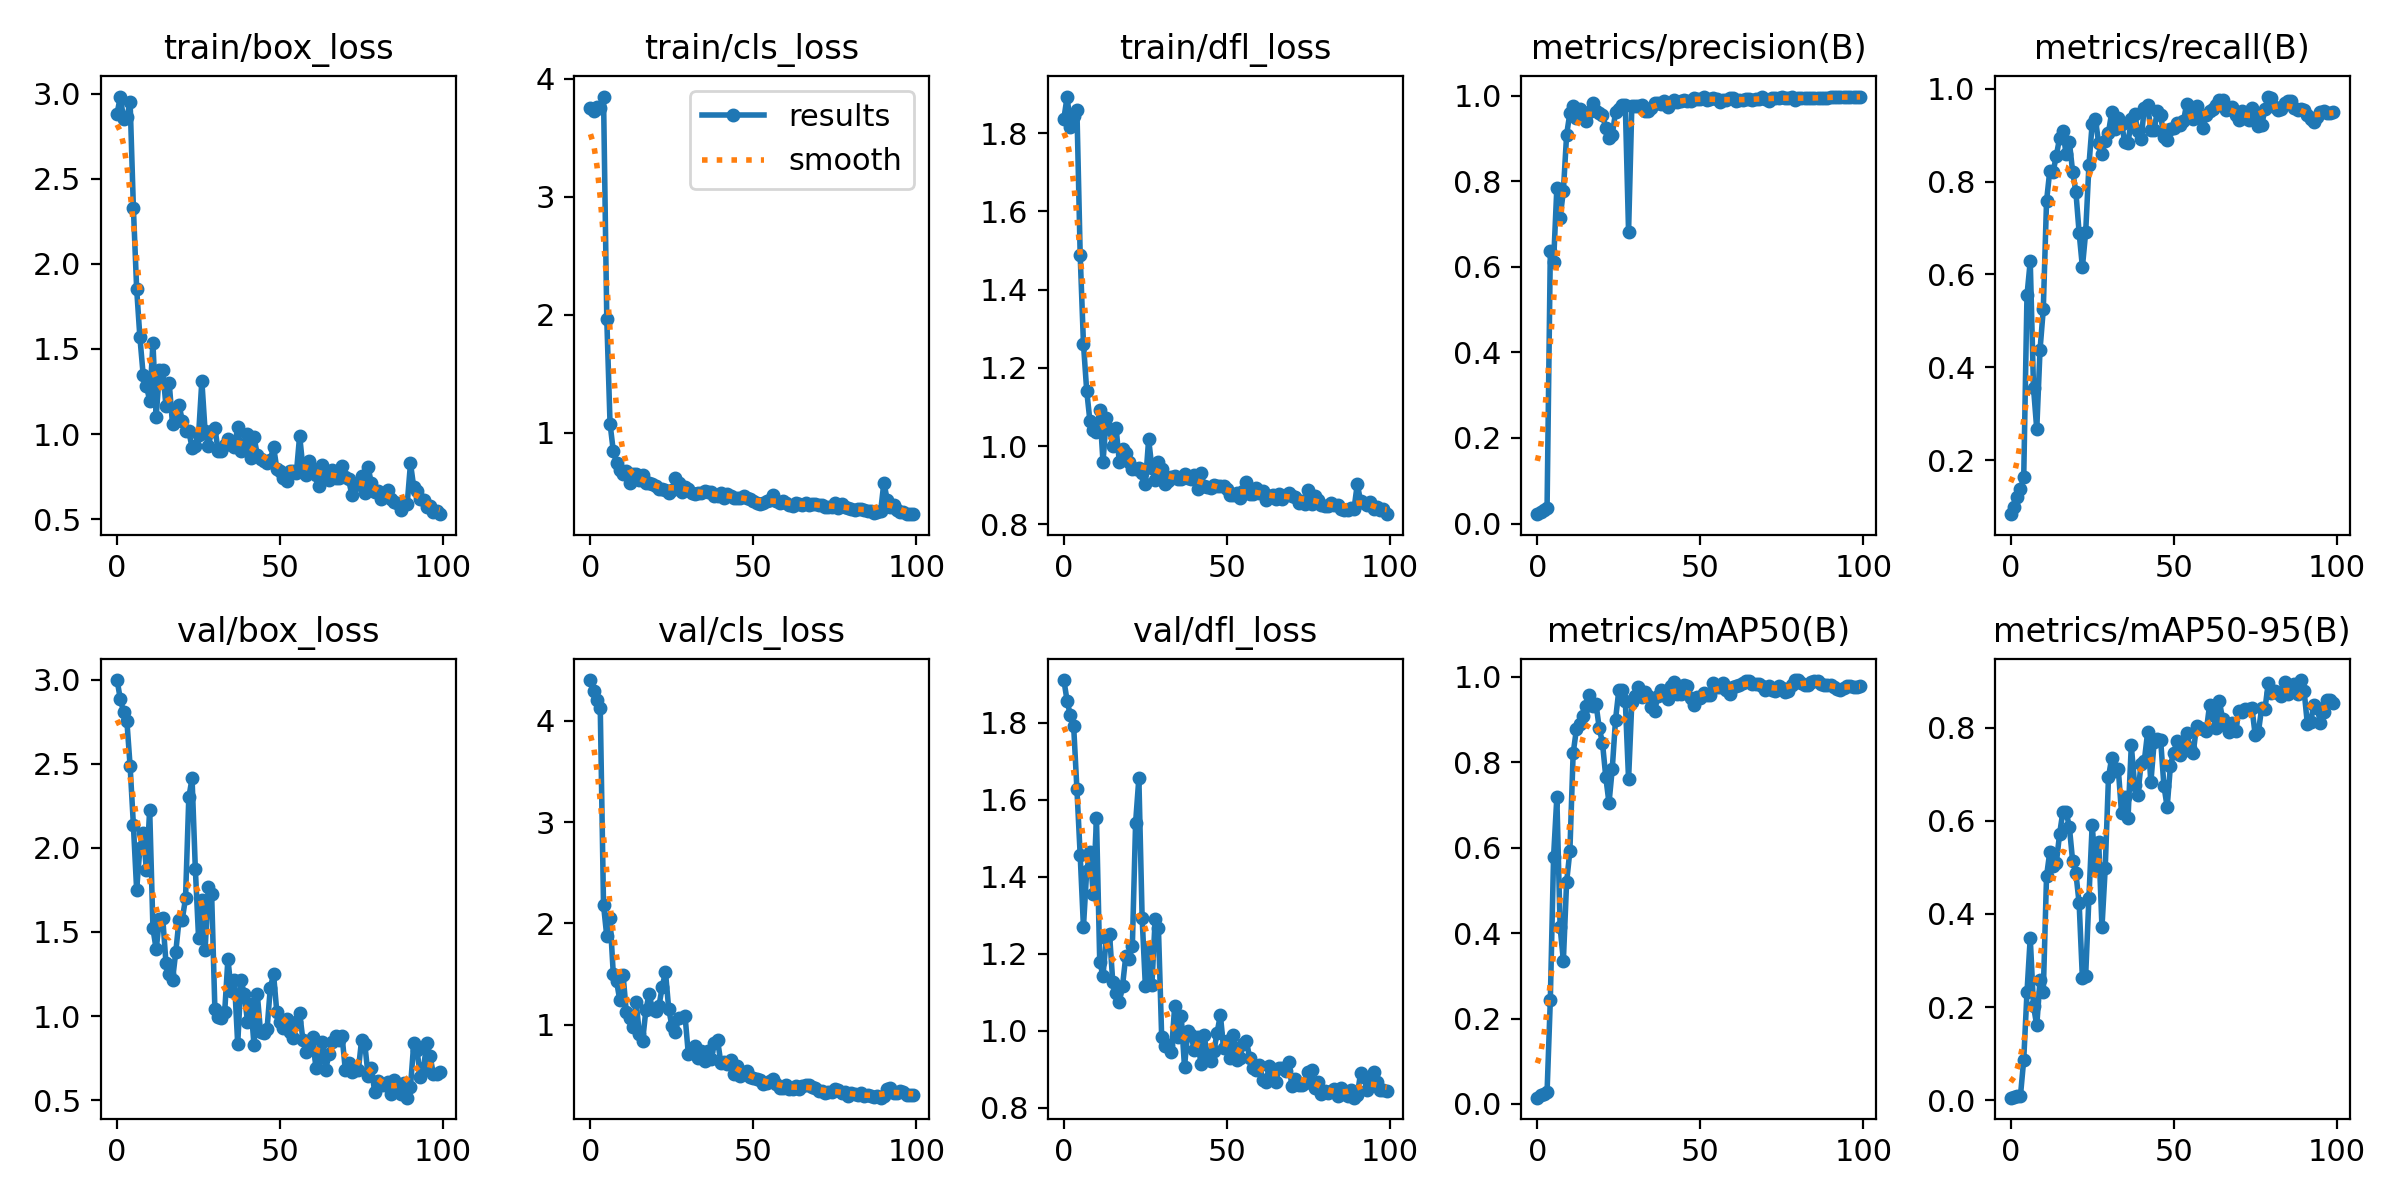

In [ ]:
image

# Annotations

## SPIDER
- Radius of each hole in the grid is 14 mm (hemsworth1996 - Original NB design);
- Design assumed the beams as two Gaussian parts, core with the 85% power with divergence of 5 mrad and the halo (15% power) with poor divergence of > 15 mrad (hemsworth1996 - Original NB design);
- Expected core beamlet divergence of as low as 2 - 3 mrad (hemsworth1996 - reference 11)